# Logistic Regression (Practice)
For this topic we will be working with the Titanic Data Set from Kaggle. This is a very famous data set and very often is a student's first step in machine learning! **We'll be trying to predict a classification- survival or deceased.**
Let's begin our understanding of implementing Logistic Regression in R for classification.

## The Data
We can begin by loading in our training data into data frames:

In [1]:
df.train <- read.csv('titanic/titanic_train.csv')

In [2]:
head(df.train)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


## Exploratory Data Analysis (EDA)
Let's explore how much missing data we have, we can use the Amelia pacakge for this. 

Warning message:
"package 'Amelia' was built under R version 3.3.3"Loading required package: Rcpp
Warning message:
"package 'Rcpp' was built under R version 3.3.3"## 
## Amelia II: Multiple Imputation
## (Version 1.7.4, built: 2015-12-05)
## Copyright (C) 2005-2017 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 


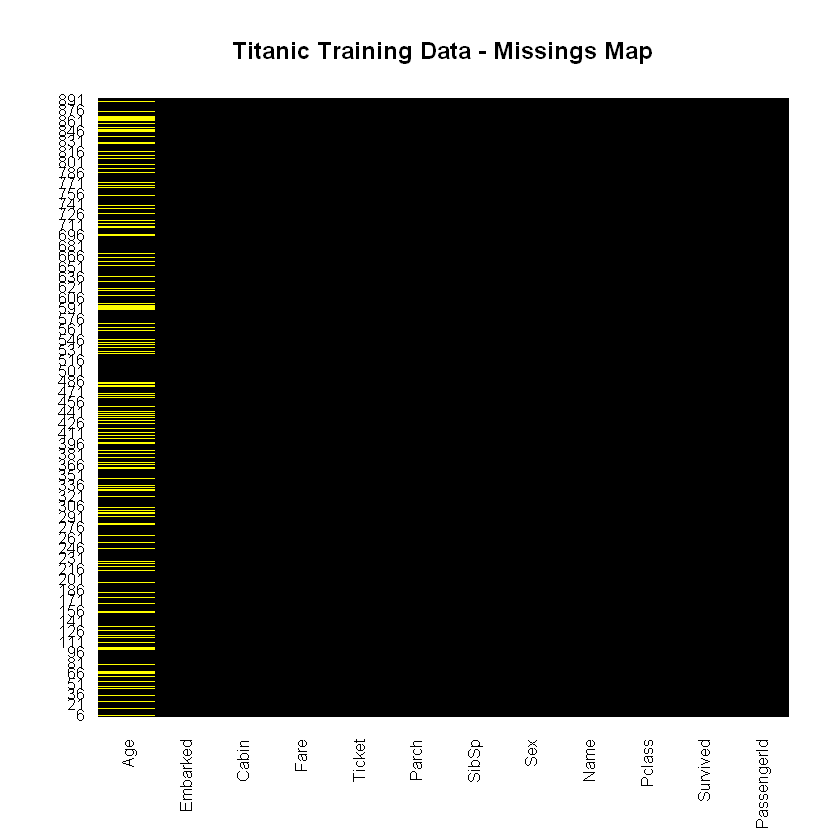

In [3]:
library(Amelia)
missmap(df.train, main="Titanic Training Data - Missings Map", 
        col=c("yellow", "black"), legend=FALSE)

Roughly 20 percent of the Age data is missing. The proportion of Age "missings" is likely small enough for reasonable replacement with some form of imputation.
Let's continue on by visualizing some of the data.

In [4]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 3.3.3"

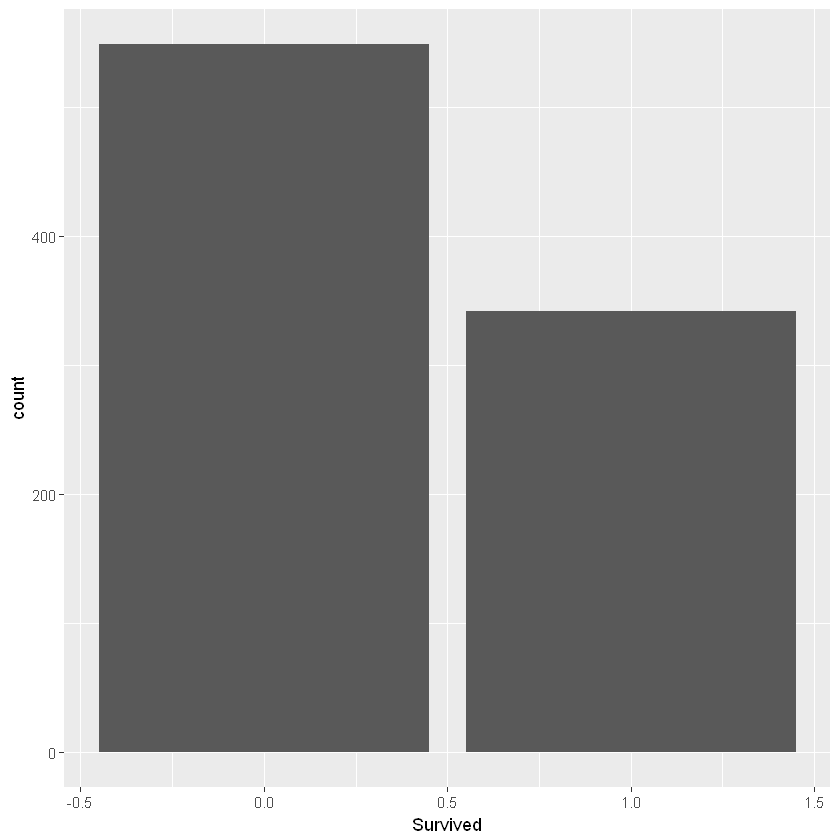

In [5]:
ggplot(df.train,aes(Survived)) + geom_bar()

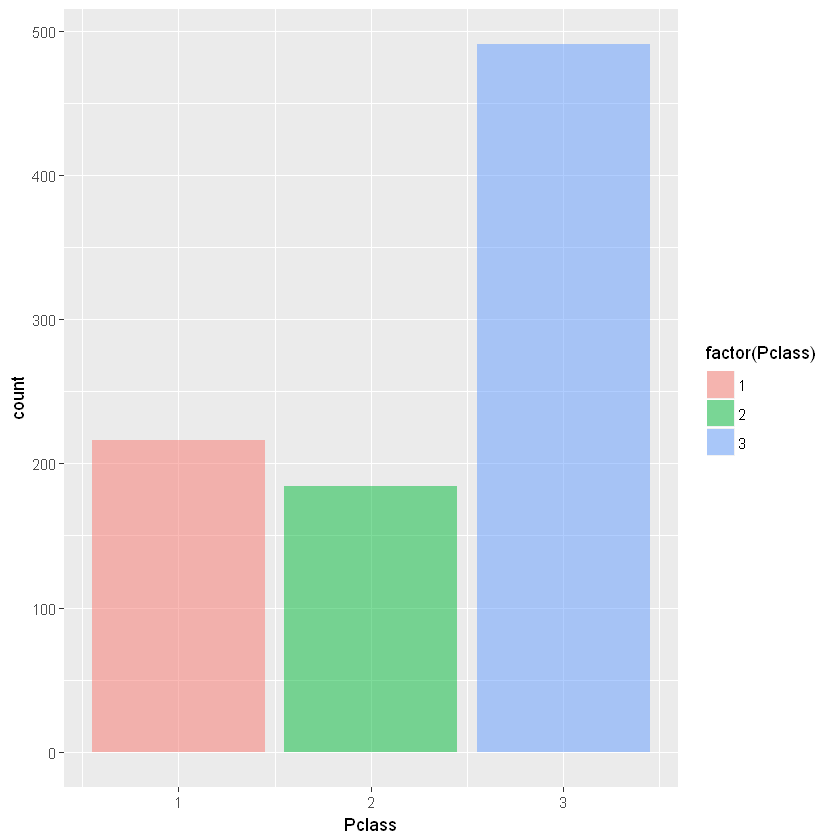

In [6]:
ggplot(df.train,aes(Pclass)) + geom_bar(aes(fill=factor(Pclass)),alpha=0.5)

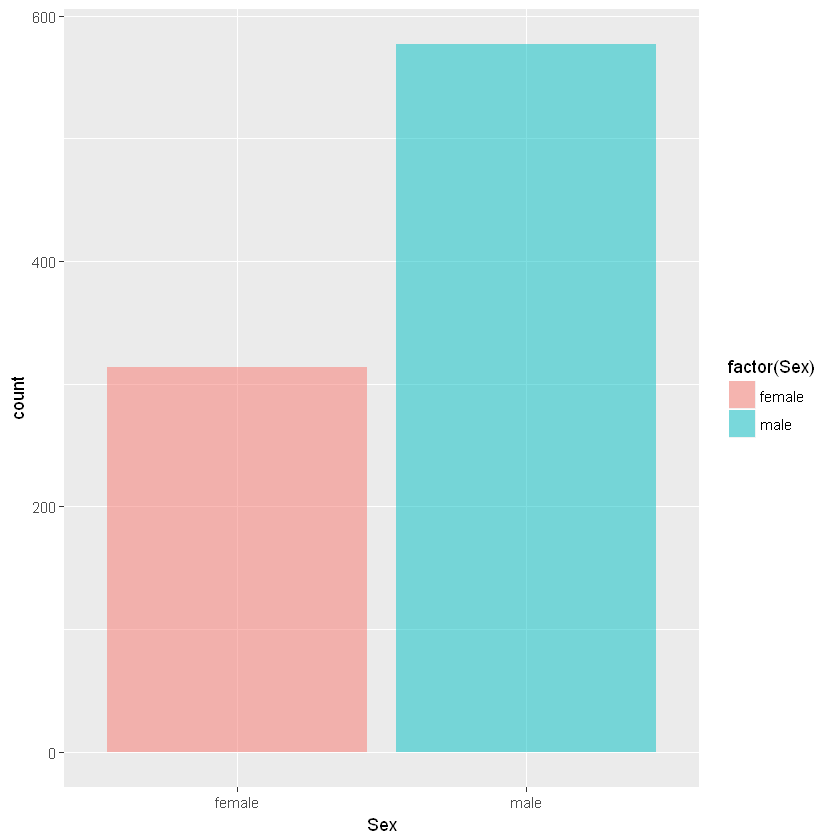

In [7]:
ggplot(df.train,aes(Sex)) + geom_bar(aes(fill=factor(Sex)),alpha=0.5)

Warning message:
"Removed 177 rows containing non-finite values (stat_bin)."

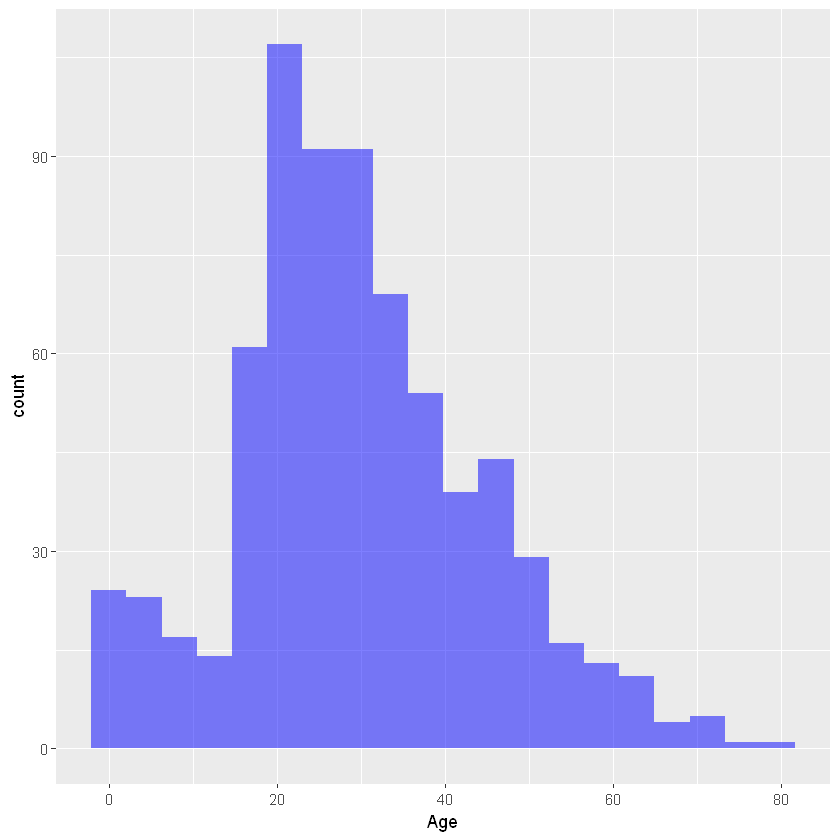

In [8]:
ggplot(df.train,aes(Age)) + geom_histogram(fill='blue',bins=20,alpha=0.5)

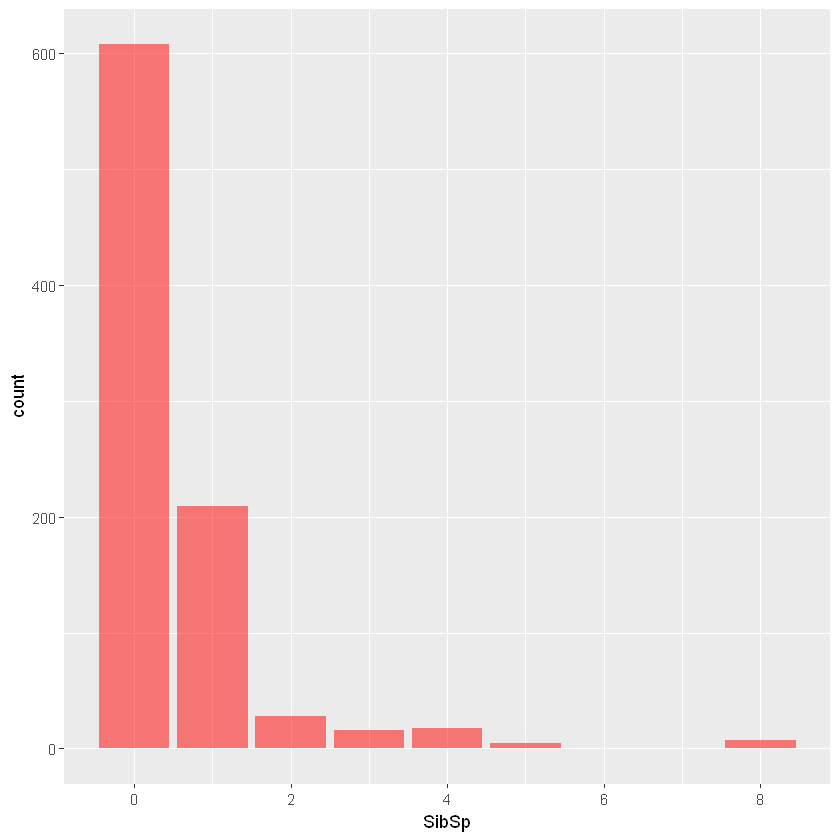

In [9]:
ggplot(df.train,aes(SibSp)) + geom_bar(fill='red',alpha=0.5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


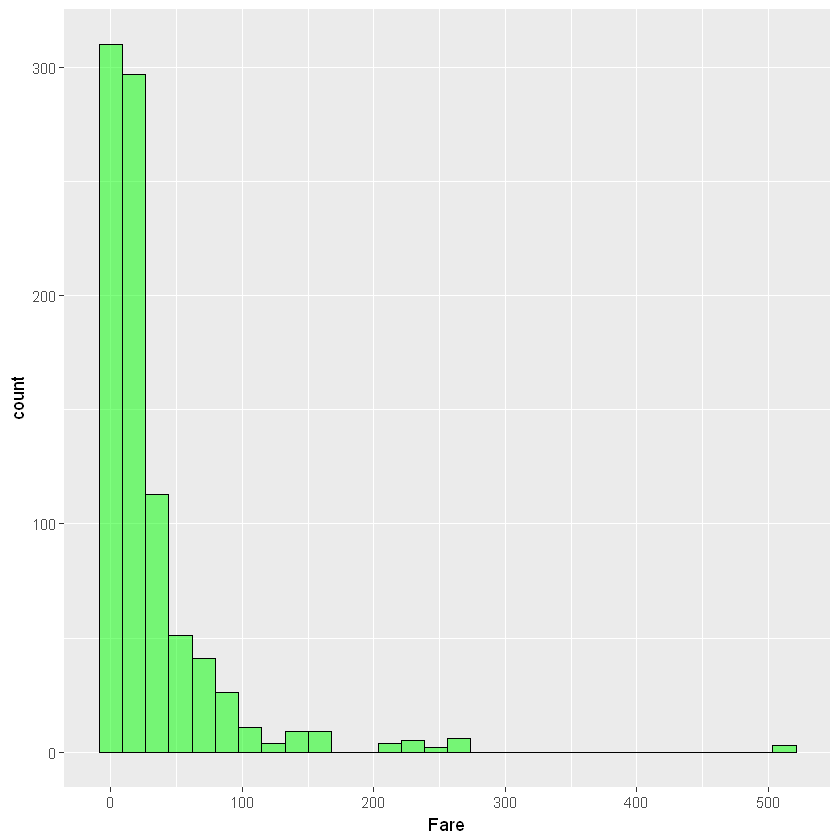

In [10]:
ggplot(df.train,aes(Fare)) + geom_histogram(fill='green',color='black',alpha=0.5)

## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).

However we can be smarter about this and check the average age by passenger class. For example:

Warning message:
"Removed 177 rows containing non-finite values (stat_boxplot)."

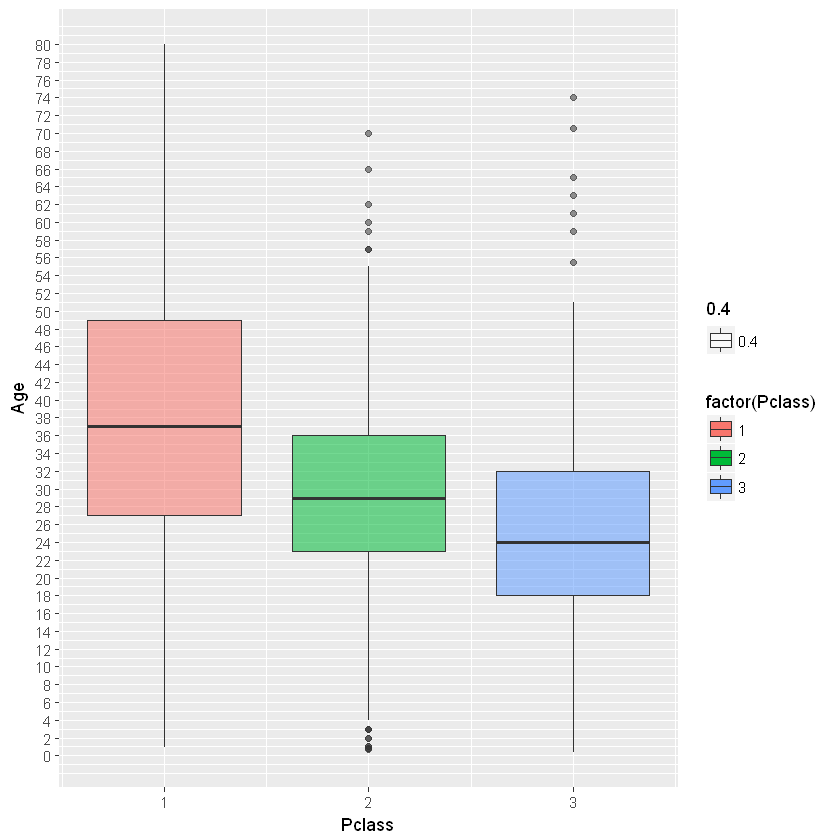

In [11]:
pl <- ggplot(df.train,aes(Pclass,Age)) + geom_boxplot(aes(group=Pclass,fill=factor(Pclass),alpha=0.4)) 
pl + scale_y_continuous(breaks = seq(min(0), max(80), by = 2))

In [12]:
impute_age <- function(age,class){
    out <- age
    for (i in 1:length(age)){
        
        if (is.na(age[i])){

            if (class[i] == 1){
                out[i] <- 37

            }else if (class[i] == 2){
                out[i] <- 29

            }else{
                out[i] <- 24
            }
        }else{
            out[i]<-age[i]
        }
    }
    return(out)
}

In [13]:
fixed.ages <- impute_age(df.train$Age,df.train$Pclass)

In [15]:
df.train$Age <- fixed.ages

Now let's check to see if it worked:

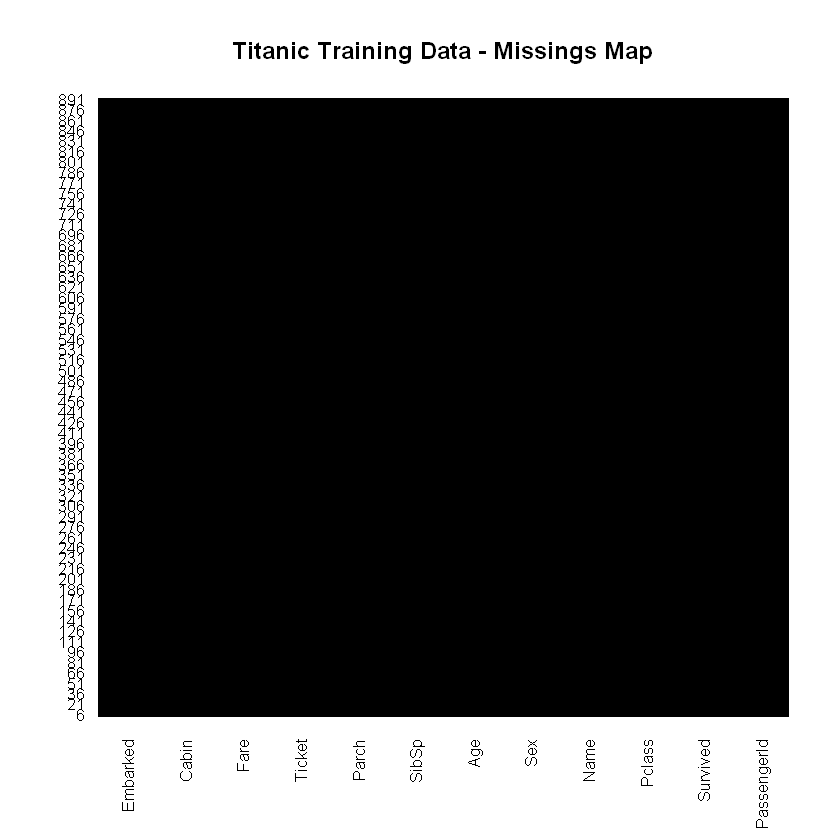

In [16]:
missmap(df.train, main="Titanic Training Data - Missings Map", 
        col=c("yellow", "black"), legend=FALSE)

Great let's continue with building our model!

## Building a Logistic Regression Model
Now it is time to build our model! Let's begin by doing a final "clean-up" of our data by removing the features we won't be using and making sure that the features are of the correct data type.

In [18]:
str(df.train)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 24 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


In [19]:
head(df.train,3)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S


Let's select the relevant columns for training:

In [20]:
library(dplyr)
df.train <- select(df.train,-PassengerId,-Name,-Ticket,-Cabin)
head(df.train,3)

Warning message:
"package 'dplyr' was built under R version 3.3.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22,1,0,7.2500,S
1,1,female,38,1,0,71.2833,C
1,3,female,26,0,0,7.9250,S


Now let's set factor columns.

In [21]:
str(df.train)

'data.frame':	891 obs. of  8 variables:
 $ Survived: int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass  : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age     : num  22 38 26 35 35 24 54 2 27 14 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked: Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


In [22]:
df.train$Survived <- factor(df.train$Survived)
df.train$Pclass <- factor(df.train$Pclass)
df.train$Parch <- factor(df.train$Parch)
df.train$SibSp <- factor(df.train$SibSp)

Train the Model
Now let's train the model!

In [23]:
log.model <- glm(formula=Survived ~ . , family = binomial(link='logit'),data = df.train)

In [24]:
summary(log.model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = df.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8158  -0.6134  -0.4138   0.5808   2.4896  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.845e+01  1.660e+03   0.011 0.991134    
Pclass2     -1.079e+00  3.092e-01  -3.490 0.000484 ***
Pclass3     -2.191e+00  3.161e-01  -6.930 4.20e-12 ***
Sexmale     -2.677e+00  2.040e-01 -13.123  < 2e-16 ***
Age         -3.971e-02  8.758e-03  -4.534 5.79e-06 ***
SibSp1       8.135e-02  2.245e-01   0.362 0.717133    
SibSp2      -2.897e-01  5.368e-01  -0.540 0.589361    
SibSp3      -2.241e+00  7.202e-01  -3.111 0.001862 ** 
SibSp4      -1.675e+00  7.620e-01  -2.198 0.027954 *  
SibSp5      -1.595e+01  9.588e+02  -0.017 0.986731    
SibSp8      -1.607e+01  7.578e+02  -0.021 0.983077    
Parch1       3.741e-01  2.895e-01   1.292 0.196213    
Parch2       3.862e-02  3.824e-01   0.101 0.919560    
Parch3   

## Predicting using Test Cases
Let's make a test set out of our training set, retrain on the smaller version of our training set and check it against the test subset.

In [25]:
library(caTools)
set.seed(101)

split = sample.split(df.train$Survived, SplitRatio = 0.70)

final.train = subset(df.train, split == TRUE)
final.test = subset(df.train, split == FALSE)

Now let's rerun our model on only our final training set:

In [26]:
final.log.model <- glm(formula=Survived ~ . , family = binomial(link='logit'),data = final.train)

In [27]:
summary(final.log.model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = final.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8288  -0.5607  -0.4096   0.6174   2.4898  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.777e+01  2.400e+03   0.007 0.994091    
Pclass2     -1.230e+00  3.814e-01  -3.225 0.001261 ** 
Pclass3     -2.160e+00  3.841e-01  -5.624 1.87e-08 ***
Sexmale     -2.660e+00  2.467e-01 -10.782  < 2e-16 ***
Age         -3.831e-02  1.034e-02  -3.705 0.000212 ***
SibSp1      -2.114e-02  2.755e-01  -0.077 0.938836    
SibSp2      -4.000e-01  6.463e-01  -0.619 0.536028    
SibSp3      -2.324e+00  8.994e-01  -2.584 0.009765 ** 
SibSp4      -1.196e+00  8.302e-01  -1.440 0.149839    
SibSp5      -1.603e+01  9.592e+02  -0.017 0.986666    
SibSp8      -1.633e+01  1.004e+03  -0.016 0.987019    
Parch1       7.290e-01  3.545e-01   2.056 0.039771 *  
Parch2       1.406e-01  4.504e-01   0.312 0.754892    
Parch3

Now let's check our prediction accuracy!

In [28]:
fitted.probabilities <- predict(final.log.model,newdata=final.test,type='response')

In [29]:
fitted.results <- ifelse(fitted.probabilities > 0.5,1,0)

In [30]:
misClasificError <- mean(fitted.results != final.test$Survived)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.798507462686567"


Looks like we were able to achieve around 80% accuracy, where as random guessing would have just been 50% accuracy. Let's see the confusion matrix:

In [31]:
table(final.test$Survived, fitted.probabilities > 0.5)

   
    FALSE TRUE
  0   140   25
  1    29   74